In [8]:
#!/usr/bin/python
"""
Copyright 2019 Accenture and/or its affiliates.  All Rights Reserved.  
You may not use, copy, modify, and/or distribute this code and/or its documentation without permission from Accenture.
Please contact the Advanced Analytics-Operations Analytics team and/or Frode Huse Gjendem (lead) with any questions.

\brief This is the starter script for the Accenture's Health Datathon 2019 competition.

\version 1.0

\date $Date: 2019/05

"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
import error_function # Inside this module you will find the function to calculate Brier error


In [9]:
######################################
# 1. Set configuration & Data Import #
######################################

# Enter your input data and output data paths below.
PATH = os.getcwd()
OUTPATH = os.getcwd()

# Set the input data folder as working directory.
os.chdir(PATH)


# Read the train & test files. 
train = pd.read_csv("datasets/train.csv",  index_col='ID')
test = pd.read_csv("datasets/test.csv", index_col='ID')

# Dividing the columns

In [10]:
numeric_clmn = ['LAB1300',  'LAB1301',  'LAB1307',  'LAB1309',
                 'LAB1311', 'LAB1313',  'LAB1314',  'LAB1316',
                 'LAB2404', 'LAB2405',  'LAB2406',  'LAB2407',
                 'LAB2419',  'LAB2422',  'LAB2467',  'LAB2469',
                 'LAB2476',  'LAB2498',  'LAB2544',  'LAB2679',
                 'LAB4176',  'MC1R', 'age',
                 'LABGF_filtrat_glomerular',
                 'cutaneous_biopsy_breslow',
                 'count_inv_prec_tumour',
                 'count_situ_prec_tumour',
                 'cutaneous_biopsy_mitotic_index',
                 'neutrofils_per_limfocits',
                 'limfocits_per_monocits',
                 'slnb_ldn_location_total',
                 'total_count_slnb_ldn',
                 'total_positives_slnb_ldn']

label_clmn = [ 'specific_death', 'months_survival']

datetime = ['T0_date']

cat_clmn = [
                'patient_eye_color',
                'patient_hair_color',
                'patient_phototype',
                'primary_tumour_location_coded',
                'cutaneous_biopsy_ulceration',
                'cutaneous_biopsy_satellitosis',
                'cutaneous_biopsy_vascular_invasion',
                'cutaneous_biopsy_neurotropism',
                'cutaneous_biopsy_lymphatic_invasion',
                'cutaneous_biopsy_predominant_cell_type',
                'cutaneous_biopsy_associated_nevus',
                'cutaneous_biopsy_histological_subtype',
                'cutaneous_biopsy_regression',
                'scenario',
                'visceral_metastasis_location']

len(numeric_clmn) + len(label_clmn) + len(datetime) + len(cat_clmn)

51

# EDA

__Categorical__

In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator

for category in cat_clmn:
    plt.figure()
    for value in train[category].unique():
        if pd.isnull(value): continue
        mask = train[category] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(train['specific_death'][mask].astype('bool'),                                  
                                                               train['months_survival'][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (value, mask.sum()))
    plt.title(category)
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()

__Numerical__

In [ ]:
import numpy as np

def fit_and_score_features(df):
    n_features = len(numeric_clmn) #X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        sel_idx = ~df[numeric_clmn[j]].isna() 
        
        Xj = df[[numeric_clmn[j]]][sel_idx]
        
        y = df[label_clmn][sel_idx]
        y['specific_death'] = y['specific_death'].astype('bool')
        y=y.to_records(index=False)

        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(train)
pd.Series(scores, index=numeric_clmn).sort_values(ascending=False)

# Data preprocessing (Albert)

In [11]:
total_null = train.isna().sum().sort_values(ascending=False)
percent = 100*(train.isna().sum()/train.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent], axis=1, keys=['Total', 'Percent'])
#missing_data

In [4]:
#train = train.drop(['ID12070'])
#train.loc['ID12070','T0_date']

#train['T0_date'] = pd.to_datetime(train['T0_date'],format='%Y-%m-%d')
# train[['T0_date']].describe()

#train['LAB1300_nan'] = train['LAB1300'].isna()
#train['LAB1300'].fillna(train['LAB1300'].mean(), inplace=True)
#train[train['LAB1300'] > 60] = True

In [5]:
train.drop('ID12070', inplace=True) #The patient is an outlier

In [12]:
def replace_outlier(df, column, threshold, direction='max'):
    fmean = df[column].mean()
    if direction == 'max':
        df[column] = df[column].apply(lambda x: fmean if x > threshold else x)
        for item in df[df[column] > threshold].index:
            df.loc[item, (column+'_nan')] = True
    elif direction == 'min':
        df[column] = df[column].apply(lambda x: fmean if x < threshold else x)
        for item in df[df[column] < threshold].index:
            df.loc[item, (column+'_nan')] = True

#df.drop('LAB1316', axis=1, inplace=True) #Highly correlated with LAB1309
#df.drop('limfocits_per_monocits', axis=1, inplace=True) #Highly correlated with LAB1309
#df.drop('slnb_ldn_location_total', axis=1, inplace=True) #83% are NaN
#df.drop('visceral_metastasis_location', axis=1, inplace=True) #98% are NaN


def clean_data(df):
    df[numeric_clmn]=df[numeric_clmn].fillna(df[numeric_clmn].mean())
    df[cat_clmn]=df[cat_clmn].fillna("default")
    
    replace_outlier(df, 'LAB1311', 2)
    replace_outlier(df, 'LAB2406', 1000)
    replace_outlier(df, 'LAB2407', 6)
    replace_outlier(df, 'LAB2476', 1000)
    replace_outlier(df, 'LAB2544', 15)
    replace_outlier(df, 'LAB4176', 60)
    replace_outlier(df, 'age', 10, 'min')
    
    df['T0_date'] = pd.to_datetime(df['T0_date'],format='%Y-%m-%d')
    
    #df = pd.get_dummies(df, columns=cat_clmn)
    return df

train = clean_data(train)

In [7]:
df = pd.get_dummies(df, columns=['cutaneous_biopsy_associated_nevus', 'month', 'year', 'scenario', 'primary_tumour_location_coded', 'patient_hair_color', 'patient_eye_color', 'cutaneous_biopsy_vascular_invasion', 'cutaneous_biopsy_ulceration', 'cutaneous_biopsy_satellitosis', 'cutaneous_biopsy_regression', 'cutaneous_biopsy_predominant_cell_type', 'cutaneous_biopsy_neurotropism', 'cutaneous_biopsy_lymphatic_invasion', 'cutaneous_biopsy_histological_subtype', 'patient_phototype','patient_gender'])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2 = df.select_dtypes(include=['float64', 'int64'])
scaler.fit(df2)
df_norm = pd.DataFrame(scaler.transform(df2), columns=df2.columns, index=df2.index)
df[df2.columns] = df_norm[df2.columns]

NameError: name 'df' is not defined

In [13]:
clmn_2drop = ['LAB1316','limfocits_per_monocits','slnb_ldn_location_total','visceral_metastasis_location']

clmn_list = train.columns.values.tolist()
clmn_exclude = (label_clmn + datetime + clmn_2drop)

for clmn_ex in clmn_exclude:
    for clmn_tr in train.columns.values.tolist():
        if clmn_ex in clmn_tr: # go to the next column in DataFrame
            clmn_list.remove(clmn_tr)

len(clmn_list)

45

# Data transformation

In [14]:
from sklearn.preprocessing import LabelEncoder
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
import error_function # Inside this module you will find the function to calculate Brier error

##########################
# 2. Data transformation #
##########################
 
# Add your feature engineering here. 

# Feature selection
#train_var
x_train = train[clmn_list]
#x_train = train[['age', 'cutaneous_biopsy_breslow']]
y_train = train[['specific_death', 'months_survival']]

In [15]:
#######################################
# 3. Prepare the data & fit the model #
#######################################

'''
@paramters
    x_train: Dataframe on which to train the model
        Format: Index = ID, Rows = patients, cols = ['Any variables you think may be predictive']
    y_train: Dependent variables on which to train the dataset
        Format: Index = ID, Rows = patients, cols = ['specific_death', 'months_survival']
    test_df: Dataframe on which to test the model
        Format: Index = ID, Rows = patients, cols = ['Any variables you think may be predictive']
@ return
    estimator: survival model
    x_test: x_test dataframe. Format: Index = ID, Rows = patients, cols = created by above
    x_train: x_train dataframe Format: Index = ID, Rows = patients, cols = created by above
    y_train: y_train dataframe Format: Index = ID, Rows = patients, cols = ['specific_death', 'months_survival']
'''
def fit_and_prepare(x_train, y_train, test_df):
    
    # 3.1. Prepare Y-----
    y_train.specific_death = y_train.specific_death.astype(bool)
    
    # Transform it into a structured array
    y_train = y_train.to_records(index = False)
    
    # 3.2. Prepare X-----
    # obtain the x variables that are categorical
    categorical_feature_mask = x_train.dtypes==object

    # Filter categorical columns using mask and turn it into a list
    categorical_cols = x_train.columns[categorical_feature_mask].tolist()

    # Ensure categorical columns are category type
    for col in categorical_cols:
        x_train[col] = x_train[col].astype('category')
        test_df[col] = test_df[col].astype('category')
    
    # 3.3. Fit model-----
    # initiate
    encoder = OneHotEncoder()
    estimator = CoxPHSurvivalAnalysis()
    
    # fit model
    #estimator.fit(encoder.fit_transform(x_train), y_train)
    x_train = encoder.fit_transform(x_train)
    estimator.fit(x_train, y_train)

    # transform the test variables to match the train
    x_test = encoder.transform(test_df)
    
    return (estimator, x_test, x_train, y_train)

# 3.1 Call the function
test=clean_data(test)
estimator, x_test, x_train, y_train = fit_and_prepare(x_train, y_train, test)

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:161: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])


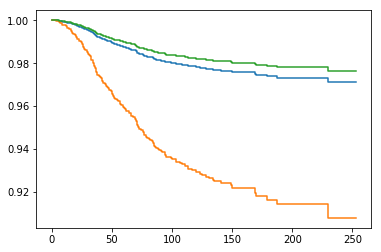

In [16]:
#############################
# 4. Perform the prediction #
#############################

# 4.1 Get the predictions (probability of being alive) for each patient in test
'''
@paramters
    x_test: Created from above function fit_and_prepare
        Format: Index = ID, Rows = patients, cols = created by above
    estimator: Created from above function fit_and_prepare; this is the model you just trained
'''
def get_probabilities(x_test, estimator):
    
    pred_surv = estimator.predict_survival_function(x_test)

    # Get the "X's" or time of each data point
    times = pred_surv[0].x

    # Create an empty pandas dataframes with these times as the columns
    pred_df = pd.DataFrame(columns = times)

    # Convert each row to a pandas series row (transpose) with the index as these x times and append it to the df
    for i in range(0, len(x_test)):
        pred_df = pred_df.append(pd.DataFrame(pred_surv[i].y).set_index(times).T) 

    pred_df = pred_df.set_index(x_test.index)

    return pred_df

# 4.2 store the predictions (920,254)
predictions = get_probabilities(x_test, estimator)

# 4.3 Compute estimate of the survival curves
pred_curves = estimator.predict_survival_function(x_test)

# Plot survival curves for certain observations (here we take first 3 observations)
for curve in pred_curves[0:3]:
    plt.step(curve.x, curve.y, where="post") 

# Checking the prediction on train/val

Overall error:  0    0.056092
dtype: float64


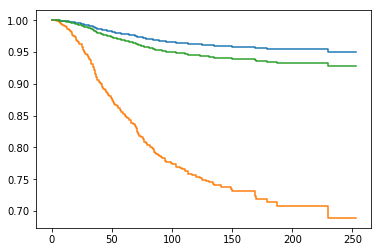

In [17]:
predictions_train = get_probabilities(x_train, estimator)
pred_curves_train = estimator.predict_survival_function(x_train)

# Plot survival curves for certain observations (here we take first 3 observations)
for curve in pred_curves_train[0:3]:
    plt.step(curve.x, curve.y, where="post") 

##########################
# 5. Calculate the error #
##########################
    
# To be filled
predictions_train = get_probabilities(x_train, estimator) 
# Here 'x_train' was already processed by encoder
# in function 'fit_and_prepare'. To use on your data, run
# 'x_2use = encoder.transform(x_df_2use)'

# Using the different module error_functions obtain the error matrix for y_test
weights = error_function.calc_weights(train[['specific_death', 'months_survival']]) 

error = error_function.brier_score_loss_weighted(pred = predictions_train,
                                                 actual = train[['specific_death', 'months_survival']], 
                                                 weights = weights, 
                                                 years_cutoff = 10)

print("Overall error: ", error)

# Calculate the error on test!

In [ ]:
##########################
# 5. Calculate the error #
##########################
    
# To be filled
# Using the different module error_functions obtain the error matrix for y_test
weights2 = error_function.calc_weights(x_test) 

error2 = error_function.brier_score_loss_weighted(pred = predictions_train,
                                                 actual = x_test, 
                                                 weights = weights, 
                                                 years_cutoff = 10)


print("Overall error: ", error2)

In [18]:
###########################
# 6 Create the submission #
###########################

# Please, remember that rows NEED TO BE indexed by patient IDs and columns MUST be ordered from T0 to T120

# First subset to 10 years
predictions_10yr = predictions.iloc[:,:121]

#Rename columns to Time periods
columns = predictions_10yr.columns.values
new_columns = ['T' + str(s) for s in columns]
predictions_10yr.columns = new_columns

# Write the final CSV file
# Please, remember than in order to make the submission you need to create a .zip file ONLY with the csv
pd.DataFrame(predictions_10yr).to_csv(OUTPATH + '/submission-cox_Elvin2.csv')

In [ ]:
OUTPATH